In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster import hierarchy
from sklearn.preprocessing import MinMaxScaler
import os, glob, inspect, sys
import re

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 
import epri_mc_lib_2 as mc
from importlib import reload
reload(mc)


<module 'epri_mc_lib_2' from '/Users/apple/Desktop/s2ds/work_project/Oct20_EPRI/Task2/NB/epri_mc_lib_2.py'>

### Import data and merge replicates

In [118]:
merged = pd.read_csv(os.path.join(os.path.dirname(os.getcwd()), '../Data/Merged_data/MERGE_FT_TEP_UT_on_ID.csv'),
                    index_col=0)
merged.index = merged.index.str.rstrip('-12345')
mean_df = merged.groupby('ID').mean()
# Get rid of cold work
cw_regex = re.compile("[0-9]+$") 
mean_df['cold_work'] = [int(re.search(cw_regex,x).group()) for x in mean_df.index]
mean_df.index = mean_df.index.str.rstrip('02468')
mean_df.index = mean_df.index.str.rstrip('-')

## Select columns of interest

In [119]:
mean_df = mean_df[mc.regression_cols].dropna()

In [120]:
mean_df.index=mean_df.index+"-"+mean_df.cold_work.astype("str")

In [121]:
mean_df.drop(["cold_work"], axis=1, inplace=True)

In [122]:
mean_df=mean_df.iloc[10:15]
mean_df

,KJIC,MS_Avg,TEP_average,Beta_avg,PC_IF_2.25MHz,PC_IF_3.5MHz,PC_BS
347-0,198.50,0.0220,-1.43700,0.002710,0.0,0.0,0.0
347-20,124.06,0.3400,-1.36400,0.001770,195.0,202.0,-25.0
347-40,89.88,1.0115,-1.27925,0.002237,182.0,241.0,-28.0
347-60,77.80,3.1390,-1.10000,0.002429,206.0,287.0,-33.0
347-80,74.00,6.3910,-0.82200,0.002559,206.0,255.0,-39.0


## Scale data

In [123]:
scaled_df = mc.scale_general(mean_df, MinMaxScaler())
scaled_df

(            KJIC    MS_Avg  TEP_average  Beta_avg  PC_IF_2.25MHz  \
 347-0   1.000000  0.000000     0.000000  1.000000       0.000000   
 347-20  0.402088  0.049929     0.118699  0.000000       0.946602   
 347-40  0.127550  0.155362     0.256504  0.496631       0.883495   
 347-60  0.030522  0.489402     0.547967  0.700772       1.000000   
 347-80  0.000000  1.000000     1.000000  0.839458       1.000000   
 
         PC_IF_3.5MHz     PC_BS  
 347-0       0.000000  1.000000  
 347-20      0.703833  0.358974  
 347-40      0.839721  0.282051  
 347-60      1.000000  0.153846  
 347-80      0.888502  0.000000  ,
 MinMaxScaler())

<AxesSubplot:>

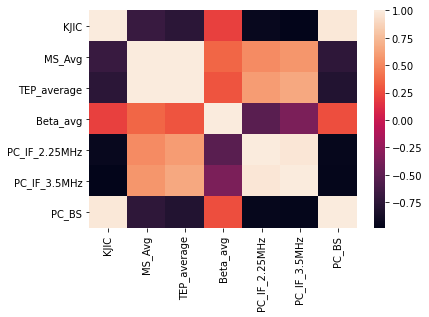

In [124]:
sns.heatmap(mean_df.corr())

In [125]:
# Creating Predictor variable 'X' and Target Variable 'y'

# X contains all the features except for the target value Price
X = mean_df.drop('KJIC', axis = 1)
y = mean_df['KJIC']

In [126]:
X

,MS_Avg,TEP_average,Beta_avg,PC_IF_2.25MHz,PC_IF_3.5MHz,PC_BS
347-0,0.0220,-1.43700,0.002710,0.0,0.0,0.0
347-20,0.3400,-1.36400,0.001770,195.0,202.0,-25.0
347-40,1.0115,-1.27925,0.002237,182.0,241.0,-28.0
347-60,3.1390,-1.10000,0.002429,206.0,287.0,-33.0
347-80,6.3910,-0.82200,0.002559,206.0,255.0,-39.0


In [127]:
from sklearn.model_selection import train_test_split

In [128]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=50)

# X_train contains 70% of total dataset
print(y_train.shape)
# X_test contains 30% of total dataset
print(X_test.shape)

(3,)
(2, 6)


In [129]:
from sklearn.linear_model import LinearRegression

In [130]:
lr = LinearRegression()

In [131]:
#Train/fit the model to training data
lr.fit(X_train,y_train)

LinearRegression()

In [132]:
# print the intercept
print(lr.intercept_)

#Coefficients
coeff_df = pd.DataFrame(lr.coef_,X.columns,columns=['Coefficient'])
coeff_df

198.4754237442384


,Coefficient
MS_Avg,-0.233612
TEP_average,-0.020679
Beta_avg,-0.000036
PC_IF_2.25MHz,0.649845
PC_IF_3.5MHz,-0.945169
PC_BS,0.406398


In [133]:
pred = lr.predict(X_test)

Text(0, 0.5, 'Predicted Fracture Toughness')

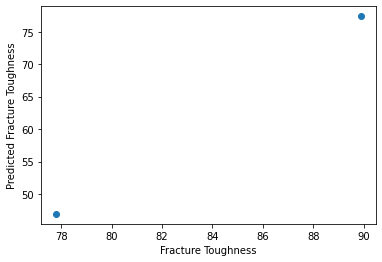

In [134]:
plt.scatter(y_test,pred)
plt.xlabel("Fracture Toughness")
plt.ylabel("Predicted Fracture Toughness")

In [135]:
from sklearn import metrics

In [136]:
print('MAE:', metrics.mean_absolute_error(y_test, pred))
print('MSE:', metrics.mean_squared_error(y_test, pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, pred)))

MAE: 21.674461570539272
MSE: 553.8177863641625
RMSE: 23.533333515763605
